<a href="https://colab.research.google.com/github/cody-little/MachineLearningwithNLP_AirBNB/blob/master/NLPwithAirBNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Natural Language Processing With Metadata: 
## A Comparison of Basic and Advanced Methods at Predicting AirBnB Price Ranges with Hybrid Feature Representations

**Summary**

This project compares naturual language processing feauture representations with metadata components for their efficacy in predicting a multiclass cost value of AirBNB listings in New York City. I compare SpaCy word embeddings to an optimized bag-of-words representation for the text description of the rental listing to see which method produces better resutls across various metrics.

### Data Intake, Cleaning and Exploration

#### Data Intake

I used Google Collab Notebooks for this analysis rather than a Jupyter Notebook running on my hardware. This allows me to remote host to a server owned by Google with much faster processing speeds and a lot more RAM than I have available. The code below simply imports the csv file for the project from my google drive. 

If you want to download the data for yoursself or to the see source I downloaded it from follow this link to the Kaggle page: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data 

The SpaCy intake cell downloads the spacy module from github and installs it to the google collab notebook. If you are going to use the syntax or run these cells to see how the work you will need to do three things. If you don't do them the notebook won't work becuase it won't properly install and run the SpaCy module



1.   Run the cell with the SpaCy comment above it that installs SpaCy from github
2.   Restart the run time
3.   Repeat step one



The cell after the import data code is just a boiler plate import cell where I bring in things I may need, I usually just copy and paste this cell from project to project because it has most of the libraries I use and I can then just alter for anything else I may need

In [1]:
#Data Intake#
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=18SLzgQfrC5ck7DbaHa7BHx4ItDIi1LLY' -O AirBNB.csv

--2020-07-12 20:18:28--  https://drive.google.com/uc?export=download&id=18SLzgQfrC5ck7DbaHa7BHx4ItDIi1LLY
Resolving drive.google.com (drive.google.com)... 172.217.212.100, 172.217.212.138, 172.217.212.139, ...
Connecting to drive.google.com (drive.google.com)|172.217.212.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-bs-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ran25ponkjekkum7pq8phv4517jbd503/1594585050000/05129054582585331303/*/18SLzgQfrC5ck7DbaHa7BHx4ItDIi1LLY?e=download [following]
--2020-07-12 20:18:28--  https://doc-14-bs-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ran25ponkjekkum7pq8phv4517jbd503/1594585050000/05129054582585331303/*/18SLzgQfrC5ck7DbaHa7BHx4ItDIi1LLY?e=download
Resolving doc-14-bs-docs.googleusercontent.com (doc-14-bs-docs.googleusercontent.com)... 108.177.111.132, 2607:f8b0:4001:c07::84
Connecting to doc-14-bs-docs.googleusercontent.com (d

In [2]:
#SpaCy Intake#
!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-2.2.0/en_core_web_md-2.2.0.tar.gz

     |████████████████████████████████| 96.4MB 48kB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.0-cp36-none-any.whl size=98072934 sha256=4fc992c3432e59a279ee743bc61fbe0007bf258b4c4f98f62f98dca72830adf7
  Stored in directory: /root/.cache/pip/wheels/5f/3e/c9/36dd6e13b449fd84cd1f94b72dfbc559daf09f53dbf4e697a3
Successfully built en-core-web-md


In [3]:
#Common libraries and things I use a lot#
import math
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import dates
import matplotlib.pyplot as plt
from datetime import datetime
import re
import calendar
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import spacy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Cleaning

The cleaning for this project is pretty standard since the data set was very workable coming from Kaggle. All I did was load it as a dataframe, drop columns I don't want for the analysis, and replace any NA's with a zero. 

While the cleaning wasn't too tedious there will be alot more to work with for the name column when I created the text feature representations. 

In [4]:
data = pd.read_csv("AirBNB.csv")
data = data.drop(['id','host_name','latitude','longitude','last_review','calculated_host_listings_count','availability_365','host_id'], axis = 1)
data = data.fillna(0)
data['name'] = data['name'].str.replace('\d+', '')
data = data.fillna(0)
data['name'] = data['name'].astype(str)
data.head()

,name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month
0,Clean & quiet apt home by the park,Brooklyn,Kensington,Private room,149,1,9,0.21
1,Skylit Midtown Castle,Manhattan,Midtown,Entire home/apt,225,1,45,0.38
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,Private room,150,3,0,0.00
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,4.64
4,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,Entire home/apt,80,10,9,0.10


#### Exploration

In [5]:
#Numerical Descriptives#
for column in data[['price', 'minimum_nights','number_of_reviews', 'reviews_per_month']]:
  print(data[column].describe())

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64
count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64
count    48895.000000
mean        23.274466
std         44.550582
min          0.000000
25%          1.000000
50%          5.000000
75%         24.000000
max        629.000000
Name: number_of_reviews, dtype: float64
count    48895.000000
mean         1.090910
std          1.597283
min          0.000000
25%          0.040000
50%          0.370000
75%          1.580000
max         58.500000
Name: reviews_per_month, dtype: float64


In [6]:
#Categorical Variable Descriptives#
for column in data[['neighbourhood', 'neighbourhood_group','room_type']]:
  print(data[column].value_counts()/len(data))

Williamsburg          0.080172
Bedford-Stuyvesant    0.075959
Harlem                0.054361
Bushwick              0.050414
Upper West Side       0.040311
                        ...   
Richmondtown          0.000020
Woodrow               0.000020
Willowbrook           0.000020
Rossville             0.000020
New Dorp              0.000020
Name: neighbourhood, Length: 221, dtype: float64
Manhattan        0.443011
Brooklyn         0.411167
Queens           0.115881
Bronx            0.022313
Staten Island    0.007629
Name: neighbourhood_group, dtype: float64
Entire home/apt    0.519665
Private room       0.456611
Shared room        0.023724
Name: room_type, dtype: float64


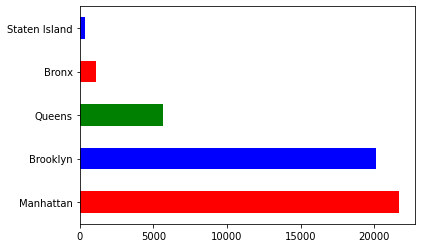

In [7]:
data['neighbourhood_group'].value_counts().plot(kind='barh', color = ['red','blue','green'])

In [8]:
#Cool visualization of room type and price#
import plotly.express as px
xdata = data[data['price'] <= 300] 
fig = px.histogram(xdata, x="price", color="room_type")
fig.show()

In [9]:
fig = px.histogram(xdata, x="price", color="neighbourhood_group")
fig.show()

### Feature Creation, Text Representation Methods, and Data Set Preperation

#### Feature Creation

In [10]:
#Create our predicted labels for a price range#
data['pricerange'] = data['price'].apply(lambda x: "Low" if x <= 75 else ("high" if x >= 175 else "medium"))
print(data['pricerange'].value_counts())
data.head(5)

medium    20708
Low       15247
high      12940
Name: pricerange, dtype: int64


,name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,pricerange
0,Clean & quiet apt home by the park,Brooklyn,Kensington,Private room,149,1,9,0.21,medium
1,Skylit Midtown Castle,Manhattan,Midtown,Entire home/apt,225,1,45,0.38,high
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,Private room,150,3,0,0.00,medium
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,4.64,medium
4,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,Entire home/apt,80,10,9,0.10,medium


#### Text Representation Methods

In this section I create two different text representation methods for the 'name' or textual feature component of the project. The first is a bag-of-words representation and the second is a 300 dimensional word embeddings using spaCy. Along with this I included some metadata feautures that I thought would be good predictors of price range labels. These included the neighbourhood group, neighbourhood, room type, and the number of reviews the listing has. 

After representing the text I split each representation into a train/validate/test split with equal proportions of outcome labels so everything is now ready to roll and we can fit some machine learning classifiers.

##### Bag of Words Creation

In [11]:
vocab_size = 1500

vectorizer = CountVectorizer(max_features=vocab_size, ngram_range=(1,2))
X = vectorizer.fit_transform(data['name'])

bow_df = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_df.columns = column_names

bow_df["pricerange"] = data["pricerange"].values 
bow_df['neighbourhood_group'] = data['neighbourhood_group'].values
bow_df['room_type'] = data['room_type'].values
bow_df['number_of_reviews'] = data['number_of_reviews'].values

#look at it#
bow_df.head(5)

,abode,ac,access,access to,across,across from,adorable,affordable,affordable room,air,airbnb,airport,airy,alcove,alcove studio,all,amazing,amazing bedroom,amazing br,amazing location,amazing room,amazing view,amazing views,amenities,an,and,and bathroom,and beautiful,and bright,and charming,and clean,and comfortable,and comfy,and convenient,and cozy,and modern,and private,and quiet,and spacious,and sunny,...,williamsburg room,window,windows,with,with amazing,with backyard,with balcony,with full,with garden,with great,with huge,with outdoor,with patio,with private,with queen,with roof,with rooftop,with terrace,with view,with yard,wonderful,woodside,world,wyndham,wyndham midtown,xl,yankee,yankee stadium,yard,york,york city,you,your,your home,your own,zen,pricerange,neighbourhood_group,room_type,number_of_reviews
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,medium,Brooklyn,Private room,9
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,high,Manhattan,Entire home/apt,45
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,medium,Manhattan,Private room,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,medium,Brooklyn,Entire home/apt,270
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,medium,Manhattan,Entire home/apt,9


##### SpaCy Embedding Creation

In [12]:
nlp = spacy.load('en_core_web_md', disable=["parser", "ner"])
def tokenize(nlp, row):
    message = row["name"]
    ix = row["id"]
    tokens = nlp(message)
    return tokens
data['id'] = data.index + 1
%time data_tag = data.apply(lambda x: tokenize(nlp, x), axis=1)

dimensions = 300

X_dict = {
    f"D{i}":[] for i in range(dimensions)
}

for row in data_tag:
  vector = row.vector
  for i in range(len(vector)):
    key = f"D{i}"
    X_dict[key].append(vector[i])

data_embed = pd.DataFrame(X_dict)
data_embed["pricerange"] = data["pricerange"].values 
data_embed['neighbourhood_group'] = data['neighbourhood_group'].values
data_embed['room_type'] = data['room_type'].values
data_embed['number_of_reviews'] = data['number_of_reviews'].values

data_embed.head(5)

CPU times: user 2min 8s, sys: 660 ms, total: 2min 8s
Wall time: 2min 8s


,D0,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31,D32,D33,D34,D35,D36,D37,D38,D39,...,D264,D265,D266,D267,D268,D269,D270,D271,D272,D273,D274,D275,D276,D277,D278,D279,D280,D281,D282,D283,D284,D285,D286,D287,D288,D289,D290,D291,D292,D293,D294,D295,D296,D297,D298,D299,pricerange,neighbourhood_group,room_type,number_of_reviews
0,0.237323,0.170987,-0.180035,-0.211945,0.080662,0.016720,0.045278,-0.151320,-0.052833,2.244075,-0.159595,-0.179196,-0.189196,0.036388,-0.277258,-0.027369,0.012716,1.229655,-0.183091,-0.001702,-0.161492,0.034520,0.184854,-0.046596,0.011572,-0.146271,-0.028384,0.061674,-0.104351,-0.020025,0.086525,-0.041293,-0.203189,0.153644,0.076416,-0.088690,0.164013,-0.057319,-0.081018,-0.055079,...,0.208249,-0.298131,-0.064670,0.012898,-0.200396,-0.065763,-0.058684,-0.092786,-0.064029,-0.139625,0.063081,-0.048952,0.151679,0.143554,-0.013506,0.153600,0.331017,-0.014108,-0.081891,0.118886,-0.196811,-0.092932,0.168049,0.049791,0.070577,-0.105432,-0.235197,0.058850,0.245541,0.222219,0.154212,0.107520,0.095230,-0.049662,-0.051474,0.135872,medium,Brooklyn,Private room,9
1,0.702537,-0.183844,0.034387,-0.487730,0.258373,-0.287966,-0.192382,0.561180,0.012570,1.365120,-0.294537,-0.388090,-0.264405,0.145463,0.248653,0.262690,0.169464,0.441993,0.088193,-0.340700,0.265217,-0.004968,0.004153,0.220211,-0.033977,-0.183426,-0.370817,-0.026407,-0.158407,0.292399,0.298607,-0.006918,-0.290440,0.247453,-0.164660,-0.139157,0.005612,0.178203,0.095683,-0.003477,...,0.001423,-0.279838,-0.210041,-0.439347,-0.849977,-0.080403,-1.004980,0.014346,-0.373710,-0.242532,0.296174,0.162930,0.179973,-0.397913,-0.013780,-0.037142,0.176840,-0.293187,-0.197397,-0.068327,-0.282200,0.330631,0.200810,0.304593,-0.026583,-0.096188,-0.004803,0.029507,0.134173,0.112237,-0.415563,-0.059874,-0.171327,0.513155,0.069340,0.308323,high,Manhattan,Entire home/apt,45
2,0.066336,0.171078,-0.070585,-0.345832,0.166052,0.072286,0.130355,-0.110396,0.129046,1.797324,-0.552149,-0.141825,-0.007003,-0.108620,-0.094383,0.095412,-0.036184,1.169855,0.000939,-0.191229,0.184233,-0.185299,0.038903,-0.048868,0.023137,-0.056840,-0.134234,0.089624,-0.073481,0.231478,0.170131,0.220887,0.107666,0.084948,0.136274,0.115567,-0.082188,0.221440,-0.059188,0.084539,...,-0.164582,-0.341652,-0.013699,-0.184481,-0.125502,0.123629,-0.471428,0.127589,-0.255909,0.058567,0.077951,-0.130998,-0.111220,0.004611,0.131117,0.087553,0.156787,-0.093974,-0.104687,0.179840,-0.165989,0.093336,0.173242,-0.018452,-0.035889,-0.089325,-0.240060,0.005926,0.048379,-0.070216,-0.019204,-0.171779,-0.080281,-0.156597,-0.229835,0.083123,medium,Manhattan,Private room,0
3,0.374053,-0.062710,0.050872,-0.081258,-0.064497,0.023985,0.032318,-0.264162,0.149786,2.099300,-0.086818,-0.145122,-0.260842,-0.010336,-0.096901,0.096765,0.094537,1.179721,-0.040834,-0.172927,-0.171362,0.080291,0.205546,0.133367,-0.049545,-0.191195,0.042108,0.117534,-0.404078,0.149220,0.220194,0.100287,-0.156310,0.245522,0.014651,-0.323640,-0.218988,0.218315,-0.303133,-0.069685,...,0.133622,-0.102136,-0.260887,-0.010380,-0.567872,-0.077848,-0.327857,-0.005129,-0.232856,-0.424314,-0.147685,-0.154370,-0.092811,0.177353,-0.040602,-0.053728,0.333608,-0.181532,-0.294293,0.048598,-0.183549,0.028269,0.136451,0.240680,-0.158397,0.030971,-0.058784,-0.021280,0.112088,0.143310,-0.400306,0.323920,-0.219672,0.129407,0.000375,-0.081361,medium,Brooklyn,Entire home/apt,270
4,0.305283,0.096377,0.028772,-0.204683,0.038650,-0.065427,-0.099055,-0.243978,-0.009999,1.770766,-0.241689,-0.160314,-0.162915,-0.022258,0.004378,0.102571,0.004579,1.489991,-0.000364,-0.080213,-0.130349,0.185430,0.116382,0.056360,-0.051815,-0.135966,-0.049227,0.142232,-0.158720,0.106560,0.151813,0.108710,-0.048942,0.167929,0.067152,0.020674,-0.182629,0.063024,-0.112726,-0.046564,...,0.029953,-0.341532,0.022262,-0.016070,-0.451589,-0.078249,-0.423898,0.028033,-0.067647,-0.258779,-0.024996,-0.143445,0.175067,-0.074053,-0.009604,0.000281,0.364598,

##### Create Data Set Splits

In [13]:
BFtrain_set, BFtest_set = train_test_split(bow_df, train_size = .80, test_size = .20)
BFvalid_set, BFtest_set = train_test_split(BFtest_set,train_size = .50, test_size = .50 )

EMBtrain_set, EMBtest_set = train_test_split(data_embed, train_size = .80, test_size = .20)
EMBvalid_set, EMBtest_set = train_test_split(EMBtest_set,train_size = .50, test_size = .50 )

print('Bag of Words Data Split Predictor Variable')
print(BFtrain_set['pricerange'].value_counts()/len(BFtrain_set))
print(BFvalid_set['pricerange'].value_counts()/len(BFvalid_set))
print(BFtest_set['pricerange'].value_counts()/len(BFtest_set))
print('_____________________________________________________')
print()
print('Word Embedding Data Split Predictor Variable')
print(EMBtrain_set['pricerange'].value_counts()/len(EMBtrain_set))
print(EMBvalid_set['pricerange'].value_counts()/len(EMBvalid_set))
print(EMBtest_set['pricerange'].value_counts()/len(EMBtest_set))

Bag of Words Data Split Predictor Variable
medium    0.423382
Low       0.311356
high      0.265262
Name: pricerange, dtype: float64
medium    0.430967
Low       0.308448
high      0.260585
Name: pricerange, dtype: float64
medium    0.417178
Low       0.319018
high      0.263804
Name: pricerange, dtype: float64
_____________________________________________________

Word Embedding Data Split Predictor Variable
medium    0.422589
Low       0.310717
high      0.266694
Name: pricerange, dtype: float64
medium    0.420536
Low       0.314175
high      0.265289
Name: pricerange, dtype: float64
medium    0.433947
Low       0.318405
high      0.247648
Name: pricerange, dtype: float64


### Model Training and Optimization on Validation Set

##### Make Training Set Splits and Get it Ready

In [14]:
#Bag of Words Training Sets#
BFX_train = BFtrain_set.drop(['pricerange'], axis = 1)
BFX_train = pd.get_dummies(BFX_train)
BFy_train = BFtrain_set['pricerange']

#Word Embedding Training Sets#
EMBX_train = EMBtrain_set.drop(['pricerange'], axis=1)
EMBX_train = pd.get_dummies(EMBX_train)
EMBy_train = EMBtrain_set['pricerange']

##### Make Validation Splits and Get it Ready

In [15]:
#Bag of Words Valid#
BFX_valid = BFvalid_set.drop(['pricerange'], axis = 1)
BFX_valid = pd.get_dummies(BFX_valid)
BFy_valid = BFvalid_set['pricerange']

#Word Embedding Valid#
EMBX_valid = EMBvalid_set.drop(['pricerange'], axis = 1)
EMBX_valid = pd.get_dummies(EMBX_valid)
EMBy_valid = EMBvalid_set['pricerange']


##### Model Explorations
The next couple of cells explore three differenct classifiers and how they perform on our validation set with both the embedding text representation and the bag of words. I use this as an oppurtunity to optimize the bag of words representation by trying out different vocabulary sizes, ngram ranges, and whether or not to include stopwards. I compared three algorithims using the base classifier from sklearn. 

1. Bernoulli Naive Bayes
2. Random Forest
3. Ada Boost

I wanted to look at a few key things here, the first is the train time, I want the algorithim to be computationally effecient. Originally I had a linear support vector machine instead of the Ada Boost but it took 27 minutes to train and never even converged on its gradient descent. The second point of interest is a quadratically weighted Cohen's Kappa Score. I like to use this metric when first evaluating classifers for multilabel classification becuase it takes into account base probability and also gives or takes away credit for predictions that are close.

*For example: Labelling low when the true label is high lowers the metric more than labelling medium when the true label is high. A quadratically weighted kappa gives a good classifier evaluation metric for multiclass problems.*

In [16]:
#Test out fitting a few different models#

#Bernoulli Naive Bayes Models#
print('Bernoulli Naive Bayes Training Times')
print('BOW')
%time BernoulliModel_BF = BernoulliNB().fit(BFX_train,BFy_train)
print('EMBED')
%time BernoulliModel_EMB = BernoulliNB().fit(EMBX_train,EMBy_train)

#RandomForestModels#
print('Random Forest Training Times')
print('BOW')
%time RandomForest_BF = RandomForestClassifier(random_state = 500).fit(BFX_train,BFy_train)
print('EMBED')
%time RandomForest_Emb = RandomForestClassifier(random_state = 500).fit(EMBX_train,EMBy_train)

#Ada Boost Classifier#
print('Ada Boost Training Times')
print('BOW')
%time AdaBoost_BF = AdaBoostClassifier(random_state = 500).fit(BFX_train,BFy_train)
print('EMBED')
%time AdaBoost_EMB = AdaBoostClassifier(random_state = 500).fit(EMBX_train,EMBy_train)

Bernoulli Naive Bayes Training Times
BOW
CPU times: user 1.11 s, sys: 245 ms, total: 1.36 s
Wall time: 1.36 s
EMBED
CPU times: user 426 ms, sys: 6.97 ms, total: 433 ms
Wall time: 413 ms
Random Forest Training Times
BOW
CPU times: user 1min 7s, sys: 147 ms, total: 1min 7s
Wall time: 1min 7s
EMBED
CPU times: user 1min 19s, sys: 31.9 ms, total: 1min 19s
Wall time: 1min 20s
Ada Boost Training Times
BOW
CPU times: user 29.1 s, sys: 15 ms, total: 29.1 s
Wall time: 29.1 s
EMBED
CPU times: user 1min 37s, sys: 34.8 ms, total: 1min 37s
Wall time: 1min 37s


In [17]:
#Predict on the validation set and get some kappa scores#
BNB_BFpreds = BernoulliModel_BF.predict(BFX_valid)
BNB_EMBpreds = BernoulliModel_EMB.predict(EMBX_valid)
RF_BFpreds = RandomForest_BF.predict(BFX_valid)
RF_EMBpreds = RandomForest_Emb.predict(EMBX_valid)
AD_BFpreds = AdaBoost_BF.predict(BFX_valid)
AD_EMBpreds = AdaBoost_EMB.predict(EMBX_valid)

#Get Kappa Scores#
#Bernoulli Naive Bayes Kappa#
BNB_BFkappa = cohen_kappa_score(BNB_BFpreds, BFy_valid, weights='quadratic')
BNB_EMBkappa = cohen_kappa_score(BNB_EMBpreds, EMBy_valid, weights='quadratic')

#Random Forest Kappas#
RF_BFkappa = cohen_kappa_score(RF_BFpreds,BFy_valid, weights='quadratic')
RF_EMBkappa = cohen_kappa_score(RF_EMBpreds, EMBy_valid, weights='quadratic')

#Ada Boost Kappas#
AD_BFkappa = cohen_kappa_score(AD_BFpreds, BFy_valid, weights='quadratic')
AD_EMBkappa = cohen_kappa_score(AD_EMBpreds, EMBy_valid, weights='quadratic')

print('________________________________')
print(f'Bernoulli Naive Bayes Bag of Words Kappa is {BNB_BFkappa:.3f}, and Embedding Kappa is {BNB_EMBkappa:.3f}')
print(f'Random Forest Bag of Words Kappa is {RF_BFkappa:.3f}, and Embedding Kappa is {RF_EMBkappa:.3f}')
print(f'Ada Boost Algorithim Bag of Words Kappa is {AD_BFkappa:.3f}, and Embedding Kappa is {AD_EMBkappa:.3f}')
print('________________________________')

________________________________
Bernoulli Naive Bayes Bag of Words Kappa is 0.447, and Embedding Kappa is 0.302
Random Forest Bag of Words Kappa is 0.500, and Embedding Kappa is 0.449
Ada Boost Algorithim Bag of Words Kappa is 0.470, and Embedding Kappa is 0.443
________________________________


##### Best Model Optimization Across Text Representations

The best of the three tested models was the base Random Forest classifer. This isn't a huge surprise given how powerful random forests can be unconstrained. Since it is unconstrained I use a grid search with cross validation for both versions of the model (the BOW representation, and the Embedding). This will give me the ideal hyperperameters for the classifier to move forward to the test set. I will again be using Cohen's Kappa Score for the metric to optimize becuase of the previously mentioned advantages that could translate into higher success on the held out data set. 

The Random Forest Base Classifer Results from Model Selection

|Text Representation|Quadratic Kappa Score|
|---|---|
|Bag of Words|.482|
|SpaCy Embeddings|.486|

*These may change if the code has re-run because of random sampling of the data splits. I have optimized the BOW representation many times and the Random Forest classifer beat out bernoulli and ada boost every iteration.*


The cell below concatenates the validation set and training set from the inital model selection and bag-of-word optimization to create a larger final training set. Using this method I can take full advantage of the number of data objects I have within the data sets and leverage that extra size to create better models. I then use a grid search to exhaustively check for a few different splitting criterion for each random forest classifier (the embedding model and the bag-of-words model). I use a 3-k fold cross validation so the training and test sizes are about the same as the intial optimization strategy but don't take five hours to search the grid. I use cohen's kappa score again as the evaluation metric to get the best model preperation I can going into the held out set. The splitting criterion for each branch of the trees is a very important hyperperameter to check out for any analysis that uses some form of decision trees.

In [18]:
#Combine Training and Validation sets#
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
BOW_Final_Train = pd.concat([BFtrain_set,BFvalid_set], ignore_index = True)
BOW_Final_TrainX = BOW_Final_Train.drop(['pricerange'], axis =1)
BOW_Final_TrainX = pd.get_dummies(BOW_Final_TrainX)
BOW_Final_Trainy = BOW_Final_Train['pricerange']
######################
#Make Embedding Data Sets#
EMB_Final_Train = pd.concat([EMBtrain_set,EMBvalid_set], ignore_index = True)
EMB_Final_TrainX = EMB_Final_Train.drop(['pricerange'], axis =1)
EMB_Final_TrainX = pd.get_dummies(EMB_Final_TrainX)
EMB_Final_Trainy = EMB_Final_Train['pricerange']
######################

#######################
#Set up grid search for criterion and forest size#
kappa_scorer = make_scorer(cohen_kappa_score)
GridRandForest_BOW = GridSearchCV(RandomForestClassifier(), param_grid={'n_estimators': [100], 'criterion': ['gini', 'entropy']}, cv = 3, scoring = kappa_scorer)
GridRandForest_EMB = GridSearchCV(RandomForestClassifier(), param_grid={'n_estimators': [100], 'criterion': ['gini', 'entropy']}, cv = 3, scoring=kappa_scorer)
#######################
#Fit the Grid Search To get optimal parameters#
%time GridRandForest_BOW.fit(BOW_Final_TrainX,BOW_Final_Trainy)
%time GridRandForest_EMB.fit(EMB_Final_TrainX,EMB_Final_Trainy)

CPU times: user 5min 49s, sys: 240 ms, total: 5min 49s
Wall time: 5min 49s
CPU times: user 12min 2s, sys: 185 ms, total: 12min 2s
Wall time: 12min 2s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [26]:
BOWBestParams = GridRandForest_BOW.best_params_
BOWBestScore = GridRandForest_BOW.best_score_
print(BOWBestParams)
print(BOWBestScore)

{'criterion': 'entropy', 'n_estimators': 100}
0.4899368984661942


In [27]:
EMBBestParams = GridRandForest_EMB.best_params_
EMBBestScore = GridRandForest_EMB.best_score_
print(EMBBestParams)
print(EMBBestScore)

{'criterion': 'entropy', 'n_estimators': 100}
0.46889876530326385


### Final Model Creation and Results

Now that we know entropy which uses information gain is the best splitting criterion we can fit our models with these hyperperameters and test them out. Below is a cell that creates the final X and y sets and then fits the classifiers returning a couple different metrics on the results.

**Results**
The results cell gives a comparison of how each feature space performed at this task. The bag-of-words representation space performed marginally better with about a 3% higher accuracy than the word embedding space. This could come to many as a surprise. Bag-of-words is a much simpler representation but that doesn't mean it can't be highly effective. The confusion matrix displays give us a better idea of what the classifiers incorrectly predicted for each group. The loss by the word embeddings random forest seems to have come from misclassifications of high priced rentals where they were incorrectly classified as medium. Both models achieved well over a baseline accuracy with this multiclass label task using a hybrid text and metadata feature space showing this is a viable method to quickly classifiy rental units in price ranges so that users can more easily sort them. Comparing different feature representations for text and how they perform with metadata is an important aspect of machine learning algorithims. This project goes to show that a more complication method such as a 300 dimensional word embedding may not always be the best choice, a bag-of-words representation performed marginally better and was computationally more efficent. 

In [31]:
###Create Final Test Sets#
BOW_Final_TESTX = BFtest_set.drop(['pricerange'], axis =1)
BOW_Final_TESTX = pd.get_dummies(BOW_Final_TESTX)
BOW_Final_TESTy = BFtest_set['pricerange']

EMB_Final_TESTX = EMBtest_set.drop(['pricerange'], axis =1)
EMB_Final_TESTX = pd.get_dummies(EMB_Final_TESTX)
EMB_Final_TESTy = EMBtest_set['pricerange']

37025      high
10761    medium
43830    medium
12583    medium
4120     medium
          ...  
27930    medium
12362      high
35134      high
12116      high
31104    medium
Name: pricerange, Length: 4890, dtype: object

In [38]:
##Fit Best Hyperperameter Model for each representation#

RandomForestBOWFinal = RandomForestClassifier(n_estimators=100,criterion='entropy').fit(BOW_Final_TrainX,BOW_Final_Trainy)
RandomForestEMBFinal = RandomForestClassifier(n_estimators = 100, criterion = 'entropy').fit(EMB_Final_TrainX, EMB_Final_Trainy)

##Predict onto the held out test set#
BOWpreds = RandomForestBOWFinal.predict(BOW_Final_TESTX)
EMBpreds = RandomForestEMBFinal.predict(EMB_Final_TESTX)

BFtest_set['predictions'] = BOWpreds
EMBtest_set['predictions'] = EMBpreds

#Get Scores for a variety of Metrics on Each to understand tradeoffs#
BOWacc = accuracy_score(BOW_Final_TESTy,BOWpreds)
EMBacc = accuracy_score(EMB_Final_TESTy, EMBpreds)
BOWkap = cohen_kappa_score(BOW_Final_TESTy,BOWpreds,weights = 'quadratic')
EMBkap = cohen_kappa_score(BOW_Final_TESTy,BOWpreds, weights = 'quadratic')
BOWf1 = f1_score(BOW_Final_TESTy,BOWpreds, average='macro')
EMBf1 = f1_score(EMB_Final_TESTy, EMBpreds, average='macro')
BOWconf = confusion_matrix(BOW_Final_TESTy,BOWpreds)
EMBconf = confusion_matrix(EMB_Final_TESTy, EMBpreds)


___________________________________________
Final Results on Test Set For Each Method
___________________________________________

Optimized Bag of Words Representation with Optimized Random Forest Classifier

Accuracy: 0.681, Kappa: 0.483
F1 Score: 0.684,



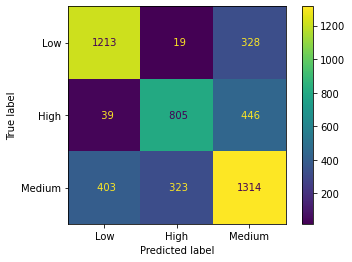


__________________________________________
Word Embeddings Representation with Optimized Random Forest Classifier

Accuracy: 0.657, Kappa: 0.483
F1 Score: 0.651,



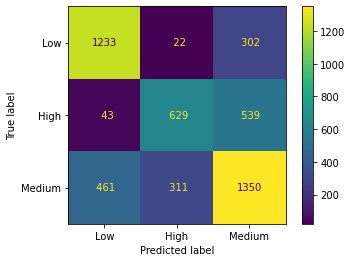

In [49]:
#Display Creation Cell#
print('___________________________________________')
print('Final Results on Test Set For Each Method')
print('___________________________________________')
print()
print('Optimized Bag of Words Representation with Optimized Random Forest Classifier')
print()
print(f'Accuracy: {BOWacc:.3f}, Kappa: {BOWkap:.3f}')
print(f'F1 Score: {BOWf1:.3f},')
print()
ConfusionMatrixDisplay(BOWconf,["Low","High","Medium"]).plot(values_format = '4g')
plt.show()
print()
print('__________________________________________')
print('Word Embeddings Representation with Optimized Random Forest Classifier')
print()
print(f'Accuracy: {EMBacc:.3f}, Kappa: {EMBkap:.3f}')
print(f'F1 Score: {EMBf1:.3f},')
print()
ConfusionMatrixDisplay(EMBconf,["Low","High","Medium"]).plot(values_format = '4g')
plt.show()
print()